In [70]:
! mkdir dipy_tests

In [71]:
! cp -r dipy* dipy_tests/

cp: cannot copy a directory, 'dipy_tests', into itself, 'dipy_tests/dipy_tests'


In [1]:
# http://nipy.org/dipy/examples_built/syn_registration_3d.html

This example explains how to register 3D volumes using the Symmetric Normalization (SyN) algorithm proposed by Avants et al. [Avants09] (also implemented in the ANTS software [Avants11])

We will register two 3D volumes from the same modality using SyN with the Cross Correlation (CC) metric.

In [25]:
import numpy as np
from dipy.data import get_fnames
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
import dipy.align.imwarp as imwarp
from dipy.viz import regtools

import matplotlib.pyplot as plt
%matplotlib inline

Let’s fetch two b0 volumes, the first one will be the b0 from the Stanford HARDI dataset

In [ ]:
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
fetch_stanford_hardi()
nib_stanford, gtab_stanford = read_stanford_hardi()
stanford_b0 = np.squeeze(nib_stanford.get_data())[..., 0]

The second one will be the same b0 we used for the 2D registration tutorial

In [3]:
from dipy.data.fetcher import fetch_syn_data, read_syn_data
fetch_syn_data()
nib_syn_t1, nib_syn_b0 = read_syn_data()
syn_b0 = np.array(nib_syn_b0.get_data())

Data size is approximately 12MB
Dataset is already in place. If you want to fetch it again please first remove the folder /home/alexn/.dipy/syn_test 
Data size is approximately 12MB
Dataset is already in place. If you want to fetch it again please first remove the folder /home/alexn/.dipy/syn_test 


In [23]:
print np.shape(stanford_b0)
print np.shape(syn_b0)

(81, 106, 76)
(128, 128, 75)


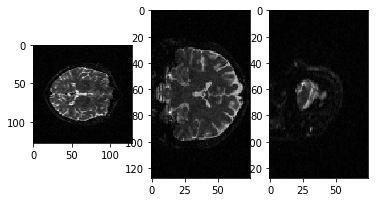

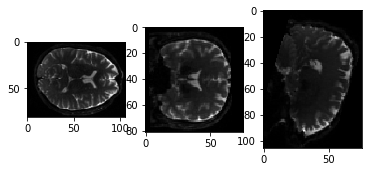

In [58]:
fig, axarr = plt.subplots(1,3)
axarr[0].imshow(syn_b0[:,:,35], cmap='gray')
axarr[1].imshow(syn_b0[:,60,:], cmap='gray')
axarr[2].imshow(syn_b0[30,:,:], cmap='gray')

fig, axarr = plt.subplots(1,3)
axarr[0].imshow(stanford_b0[:,:,35], cmap='gray')
axarr[1].imshow(stanford_b0[:,60,:], cmap='gray')
axarr[2].imshow(stanford_b0[30,:,:], cmap='gray')

We first remove the skull from the b0’s

In [4]:
from dipy.segment.mask import median_otsu
stanford_b0_masked, stanford_b0_mask = median_otsu(stanford_b0, 4, 4)
syn_b0_masked, syn_b0_mask = median_otsu(syn_b0, 4, 4)

static = stanford_b0_masked
static_affine = nib_stanford.affine
moving = syn_b0_masked
moving_affine = nib_syn_b0.affine

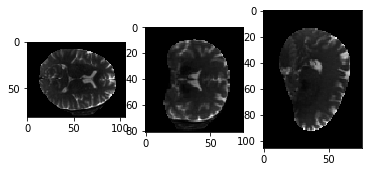

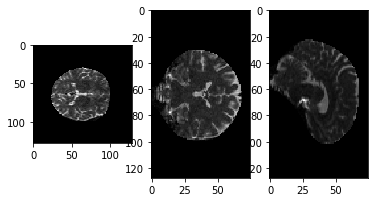

In [63]:
fig, axarr = plt.subplots(1,3)
axarr[0].imshow(static[:,:,35], cmap='gray')
axarr[1].imshow(static[:,60,:], cmap='gray')
axarr[2].imshow(static[30,:,:], cmap='gray')

fig, axarr = plt.subplots(1,3)
axarr[0].imshow(moving[:,:,35], cmap='gray')
axarr[1].imshow(moving[:,60,:], cmap='gray')
axarr[2].imshow(moving[60,:,:], cmap='gray')

Suppose we have already done a linear registration to roughly align the two images

In [5]:
pre_align = np.array([[1.02783543e+00, -4.83019053e-02, -6.07735639e-02, -2.57654118e+00],
                      [4.34051706e-03, 9.41918267e-01, -2.66525861e-01, 3.23579799e+01],
                      [5.34288908e-02, 2.90262026e-01, 9.80820307e-01, -1.46216651e+01],
                      [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

As we did in the 2D example, we would like to visualize (some slices of) the two volumes by overlapping them over two channels of a color image. To do that we need them to be sampled on the same grid, so let’s first re-sample the moving image on the static grid. We create an AffineMap to transform the moving image towards the static image

In [12]:
from dipy.align.imaffine import AffineMap
affine_map = AffineMap(pre_align,
                       static.shape, static_affine,
                       moving.shape, moving_affine)

resampled = affine_map.transform(moving)

plot the overlapped middle slices of the volumes

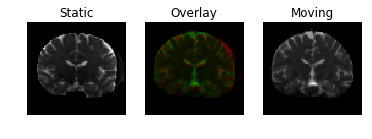

In [13]:
regtools.overlay_slices(static, resampled, None, 1, 'Static', 'Moving', 'input_3d.png')

(128, 128, 75)
(81, 106, 76)


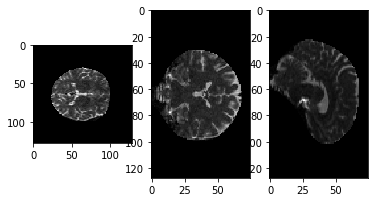

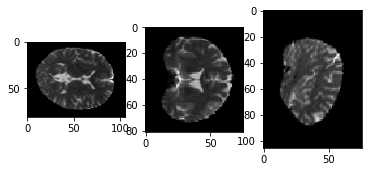

In [68]:
fig, axarr = plt.subplots(1,3)
axarr[0].imshow(moving[:,:,35], cmap='gray')
axarr[1].imshow(moving[:,60,:], cmap='gray')
axarr[2].imshow(moving[60,:,:], cmap='gray')

fig, axarr = plt.subplots(1,3)
axarr[0].imshow(resampled[:,:,35], cmap='gray')
axarr[1].imshow(resampled[:,60,:], cmap='gray')
axarr[2].imshow(resampled[60,:,:], cmap='gray')

print np.shape(moving)
print np.shape(resampled)

We want to find an invertible map that transforms the moving image into the static image. We will use the Cross Correlation metric

In [14]:
metric = CCMetric(3)

Now we define an instance of the registration class. The SyN algorithm uses a multi-resolution approach by building a Gaussian Pyramid. We instruct the registration object to perform at most `[n0,n1,...,nk]` iterations at each level of the pyramid. The 0-th level corresponds to the finest resolution.

In [15]:
level_iters = [10, 10, 5]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)

Execute the optimization, which returns a DiffeomorphicMap object, that can be used to register images back and forth between the static and moving domains. We provide the pre-aligning matrix that brings the moving image closer to the static image

In [16]:
mapping = sdr.optimize(static, moving, static_affine, moving_affine, pre_align)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0


Now let’s warp the moving image and see if it gets similar to the static image

In [17]:
warped_moving = mapping.transform(moving)

We plot the overlapped middle slices

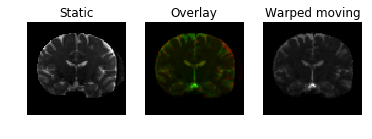

In [18]:
regtools.overlay_slices(static, warped_moving, None, 1, 'Static', 'Warped moving', 'warped_moving.png')

And we can also apply the inverse mapping to verify that the warped static image is similar to the moving image

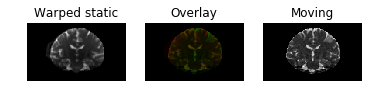

In [19]:
warped_static = mapping.transform_inverse(static)
regtools.overlay_slices(warped_static, moving, None, 1, 'Warped static', 'Moving', 'warped_static.png')